## Basic Settings

In [3]:
import sklearn as sk
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt

In [2]:
doc_path = "Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/"
working_path = "C:/Users/Jesper/Google Drive/Uni docs/Statistik/Machine Learning/project/"

## Loading the data
* Metainformatioon is provided in a seperate .csv file. The target Variable is "guten_genre"
* The documents are stored in a folder. They seem to be quite big when loaded in an sklearn dataset, so maybe we can not work with all the books stored in memory. 
* Alternatively we will have to pass filenames to some feature extraction method that will than return the extracted features.

In [3]:
meta = pd.read_csv(working_path+"Gutenberg_English_Fiction_1k/master996.csv", sep=";",
           header=0, encoding='latin1')

In [4]:
meta

,Book_Name,book_id,guten_genre,Author_Name
0,The Mystery of the Boule Cabinet: A Detective ...,pg10067.epub,Detective and Mystery,Stevenson| Burton Egbert
1,The Pupil,pg1032.epub,Literary,James| Henry
2,At Love's Cost,pg10379.epub,Literary,Garvice| Charles
3,The Heart of the Range,pg10473.epub,Western Stories,White| William Patterson
4,The Worshipper of the Image,pg10812.epub,Literary,Gallienne| Richard Le
...,...,...,...,...
991,David Copperfield,pg766DickensDavidCopfld.epub,Literary,Dickens| Charles
992,Hard Times,pg786DickensHardTimes.epub,Literary,Dickens| Charles
993,Memoirs of Shelock Holmes,pg834DoyleMemoirsSherlk.epub,Detective and Mystery,Connan| Doyle
994,The Mysterious Affair at Styles,pg863Agatha1.epub,Detective and Mystery,Christie| Agatha


In [5]:
#Extract target Variable and filenames
target = meta["guten_genre"]
book_id = meta["book_id"]
filenames = [doc_path+id.split(".")[0]+"-content.html" for id in book_id]

In [6]:
filenames

['Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10067-content.html',
 'Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg1032-content.html',
 'Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10379-content.html',
 'Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10473-content.html',
 'Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10812-content.html',
 'Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10826-content.html',
 'Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10943-content.html',
 'Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg11004-content.html',
 'Gutenberg_English_Ficti

In [12]:
target.value_counts()
#The dataset is highly unbalanced, a classifier that only predicts
#"Literay" will get 79% Accuracy!

Literary                       794
Detective and Mystery          111
Sea and Adventure               36
Love and Romance                18
Western Stories                 18
Humorous and Wit and Satire      6
Ghost and Horror                 6
Christmas Stories                5
Allegories                       2
Name: guten_genre, dtype: int64

In [100]:
#Making train and test-dataset
from sklearn.model_selection import train_test_split
filenames_train, filenames_test, y_train, y_test = train_test_split(
                filenames, target, test_size=0.33)

In [53]:
#This will only work if "load_content=False". But its probably not usefull, 
#because it contains the files that are unlabelled.
#from sklearn import datasets
#data = datasets.load_files("Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k",
#                   shuffle=False, load_content=False)

## Train simple Bow model
* We will pass input=filename to the vectorizer. This will go through the files individually.

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = CountVectorizer(input = "filename")
train_vectors = vectorizer.fit_transform(filenames_train)
test_vectors = vectorizer.transform(filenames_test)

In [120]:
vectorizer.vocabulary_

{'transcriber': 123161,
 'note': 83234,
 'there': 120484,
 'were': 133774,
 'number': 83511,
 'of': 84297,
 'printer': 94858,
 'errors': 41692,
 'within': 135290,
 'the': 120305,
 'text': 120159,
 'which': 134162,
 'have': 56020,
 'not': 83212,
 'been': 11813,
 'altered': 4929,
 'it': 64473,
 'was': 132996,
 'just': 66208,
 'sunset': 117053,
 'as': 7899,
 'matthew': 75533,
 'pikeman': 91252,
 'went': 133755,
 'out': 85932,
 'to': 121905,
 'receive': 98904,
 'toll': 122114,
 'from': 48688,
 'some': 112192,
 'one': 84794,
 'passing': 88358,
 'or': 85178,
 'rather': 98340,
 'coming': 25456,
 'quickly': 97301,
 'up': 129236,
 'gate': 50135,
 'market': 74805,
 'day': 31740,
 'at': 8490,
 'brampton': 16057,
 'so': 111738,
 'had': 54645,
 'keep': 66650,
 'his': 57855,
 'ears': 38630,
 'open': 85012,
 'and': 5659,
 'wits': 135321,
 'about': 2093,
 'him': 57665,
 'for': 47208,
 'generally': 50500,
 'he': 56212,
 'lazy': 69431,
 'post': 93486,
 'with': 135257,
 'scarcely': 105771,
 'half': 54841

In [121]:
#Importing model for classification (here Naive Bayes)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train_vectors, y_train)
#Measuring accuracy on the training set
np.mean(nb.predict(train_vectors) == y_train)

0.9580209895052474

In [124]:
np.mean(nb.predict(test_vectors) == y_test)
#~10% Validation error! Only ~7% Above baseline this can be better!

0.8601823708206687

## How might we extract features?
* I want to illustrate how we could extract some features by only using the filenames. I will use the simplest possible feature: number of characters, which should indicate plot complexity to some extend.
* Also I think one possible workflow could be to split up the feature extraction by some theretical consideration (semantic vs. syntactic e.g.).

In [9]:
#Extract features takes a method (extractor) and filenames
#as argument and returns one feature. We could wrap this up by concatenating
#and just hand over a list of extracors to get our dataset ready.
def extract_feature(extractor, filenames):
    feature = []
    for filename in filenames:
        file = open(filename, "r", encoding="utf8")
        text = file.read()
        feature.append(extractor(text)) #type: String
        file.close()
    return(feature)

In [7]:
def extract_features(extractor_list, filenames):
    feature = [[]]
    for filename in filenames:
        file = open(filename, "r", encoding="utf8")
        text = file.read()
        text = word_tokenize(text)
        feature.append([extractor(text) for extractor in extractor_list]) #type: word_tokenizer
        file.close()
    return(feature)

## Extractors
(Put all Extractors here)

In [5]:
#word_length = extract_feature(len, filenames)
# Named entity recognition features. Loading the JSON file returns a dictionary where,
# --- KEY = filename
#
# --- VALUE = {
# Number of sentences,
# Number of dialogs,
# Number of persons in text,
# List of persons in text,
# Number of places in text,
# List of places in text,
# Number of organizations in text,
# List of organizations in text,
# }
ner_features_path = "../features/ner_features.json"
with open(ner_features_path, 'r') as json_file:
    ner_features = json.load(json_file)
print(ner_features)

{'/home/richhiey/Desktop/workspace/academics/courses/semester_4/Advanced Topics in Machine Learning/course_project/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10067-content.html': {'n_sentences': 2283, 'n_dialogs': 2476.5, 'n_sentences_with_dialogs': 1649, 'places': ['la', 'Huchette', 'Sixteenth', 'France', 'Bretagne', 'Cod', 'Navarre', 'Normandy', 'Cherbourg', 'Fifteenth', 'Adriatic', 'Building', 'Fifth', 'Mazarin', 'Twenty-third', 'York', 'Street', 'Great', 'de', 'Rue', 'Flatiron', 'Saint', 'Antwerp', 'Pittsburgh', 'Vantines', 'Waterloo', 'Jacques', 'Quebec', 'Crochard', 'Godfrey', 'Florence', 'Philadelphia', 'Touraine', 'Westchester', 'Elixi', 'New', 'Provence', 'City', 'Avenue', 'Paris', 'Iowa', 'Plantin-Moretus', 'Sixth', 'Louvre', 'Unknown', 'Café', 'Island', 'Simmonds', 'Square', 'Osage', 'Madame', 'Coney', 'Washington', 'Tenth', 'Vincennes', 'Madison', 'Boston', 'Duke', 'La', 'Cape', 'Montespan', 'Liberty', 'Broadway', 'Louis', 'Versailles', 'Europe', 

Text(0.5, 1.0, 'Histogramm Number of Characters in documents')

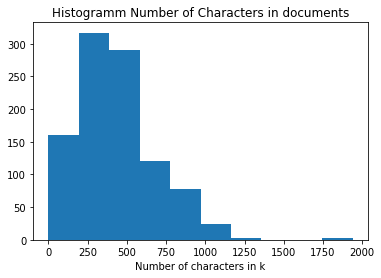

In [149]:
plt.hist(np.divide(np.asarray(word_length),1000))
plt.xlabel("Number of characters in k")
plt.title("Histogramm Number of Characters in documents")

In [7]:
#Now I use NLTK for the extraction of some simple feature
import nltk
#nltk.download()

In [8]:
from nltk import word_tokenize
def n_words_extractor(text):
    return(len(word_tokenize(text)))

In [161]:
#This is kind of slow. Maybe we have to write a different wraper for extraction
#with NLTK.
word_count = extract_feature(n_words_extractor, filenames)

Text(0.5, 1.0, 'Histogramm Number of Words per Document')

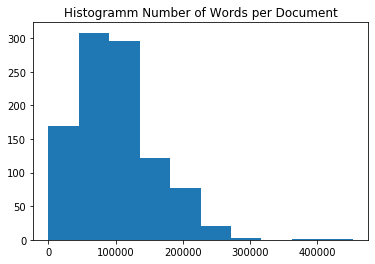

In [164]:
plt.hist(word_count)
plt.title("Histogramm Number of Words per Document")

In [14]:
from  nltk.sentiment.util import mark_negation

In [21]:
mark_negation("I do not like Cheese".split())

['I', 'do', 'not', 'like_NEG', 'Cheese_NEG']

## Feature Selection

## Model training